In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from statsmodels.tsa.api import ExponentialSmoothing
from datetime import date

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


# CITYWIDE

In [2]:
cut_off = '2025-06-01'
last_cut_off = '2025-12-20'
last_day = '2025-12-31'

In [3]:
df = pd.read_csv('../scr/data/cleaned_rat_sightings_data/cleaned_rat_sightings.csv')
df['created_date'] = pd.to_datetime(df['created_date']) 
daily_counts = df.groupby(df['created_date'].dt.date).size().reset_index(name='count')
df = daily_counts
df['created_date'] = pd.to_datetime(df['created_date']) 

In [4]:
df_test = df[df['created_date']>=cut_off].copy()
df_train = df[df['created_date']<cut_off].copy()

holt_winters = ExponentialSmoothing(df_train['count'].values,
                                      seasonal='add',
                                      seasonal_periods=365).fit(optimized = True)

In [5]:
rs = pd.read_csv('../scr/data/cleaned_rat_sightings_data/cleaned_rat_sightings.csv')

In [6]:
rs['created_date'] = pd.to_datetime(rs['created_date']) 
rs['closed_date'] = pd.to_datetime(rs['closed_date'])
rs['resolution_action_updated_date'] = pd.to_datetime(rs['resolution_action_updated_date'])


# Start by cutting off datas before 2020-01-01 and after 2025-12-31.

rs = rs[rs['created_date']<=last_day]
rs = rs[rs['created_date']>='2020-01-01']


day_before_obj = datetime.datetime.strptime(cut_off, '%Y-%m-%d') - datetime.timedelta(days=1)
# Convert back to string (date only)
before_cut_off = day_before_obj.strftime('%Y-%m-%d')

rs_train = rs[rs['created_date']<cut_off]
rs_test = rs[rs['created_date']>=cut_off]

In [7]:
nrs_test = rs_test.groupby([rs_test['created_date'].dt.date]).size().reset_index(name='count')

nrs_train = rs_train.groupby([rs_train['created_date'].dt.date]).size().reset_index(name='count')

full_range = pd.date_range(start="2020-01-01", end=before_cut_off, freq='D')

# reindex and fill missing dates with 0
nrs_train = nrs_train.set_index('created_date').reindex(full_range, fill_value=0).rename_axis('created_date').reset_index()

full_range = pd.date_range(start=cut_off, end="2025-12-31",freq='D')

# reindex and fill missing dates with 0
nrs_test = nrs_test.set_index('created_date').reindex(full_range, fill_value=0).rename_axis('created_date').reset_index()

def seasonal_average_forecast(data, target_dates, years_back=5, day_window=5):
    df = data.copy()
    # ensure datetime type
    df["created_date"] = pd.to_datetime(df["created_date"])
    df["doy"] = df["created_date"].dt.dayofyear
    df["year"] = df["created_date"].dt.year

    forecasts = []
    for target_date in target_dates:
        target_doy = target_date.dayofyear
        target_year = target_date.year
        mask = ((df["year"] >= target_year - years_back) & (df["year"] < target_year) & (np.abs(df["doy"] - target_doy) <= day_window))
        forecasts.append(df.loc[mask, "count"].mean())
    return pd.Series(forecasts, index=target_dates)


# define future dates
# number of years to forecast
# years_to_forecast = 1

years_back = 5
day_window = 5

last_date = nrs_train["created_date"].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(nrs_test), freq="D")

forecast = seasonal_average_forecast(nrs_train, future_dates, years_back=years_back, day_window = day_window)


In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(120, 50), sharex=False)

## Holt-Winters Plot

ax1.plot(df_train['created_date'], df_train['count'], 'o', color='b', label="Training Data", alpha=1, markersize=10)
ax1.plot(df_train['created_date'], holt_winters.fittedvalues, 'g-', label="Holt-Winters Fit", linewidth=8)
ax1.plot(df_test['created_date'], df_test['count'], 'o', color='b', label="Test Data", alpha=0.3, markersize=10)

hw_forecast = holt_winters.forecast(len(df_test['created_date']))
ax1.plot(df_test['created_date'], hw_forecast, color='black', label="Holt-Winters Predictions", linewidth=8)

ax1.grid(True)

ax1.set_xlabel("Date", fontsize=75)
ax1.set_ylabel("Rat Sightings by Day", fontsize=75)
ax1.tick_params(axis='x', labelsize=80)
ax1.tick_params(axis='y', labelsize=80)

ax1.set_title(f"Holt-Winters Prediction Trained on Data Before and Tested on Data After {cut_off}", fontsize=90)

# Metrics
rmse_hw = np.sqrt(np.mean((df_test['count'] - hw_forecast) ** 2))
rss_hw = np.sum((df_test['count'] - hw_forecast) ** 2)

text_box_hw = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse_hw:.2f}')
text_box2_hw = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss_hw:.2f}')

handles, labels = ax1.get_legend_handles_labels()
handles.extend([text_box_hw, text_box2_hw])
labels.extend([f"RMSE: {rmse_hw:.2f}", f"RSS: {rss_hw:.2f}"])
ax1.legend(handles=handles, labels=labels, fontsize=75)


## Seasonal Average Plot

ax2.plot(nrs_train["created_date"], nrs_train["count"], "o", color="b", markersize=10, label="Observed (Train)")
ax2.plot(forecast.index, forecast.values, color="black", linewidth=5, linestyle="-", label="Seasonal Avg Forecast")
ax2.plot(nrs_test["created_date"], nrs_test["count"], "o", color="b", markersize=10, alpha=0.3, label="Observed (Test)")

ax2.grid(True)
ax2.set_xlabel("Date", fontsize=75)
ax2.set_ylabel("Rat Sightings by Day", fontsize=75)
ax2.tick_params(axis='x', labelsize=80)
ax2.tick_params(axis='y', labelsize=80)

# Metrics
rmse_sa = np.sqrt(np.mean((nrs_test['count'] - forecast.values) ** 2))
rss_sa = np.sum((nrs_test['count'] - forecast.values) ** 2)

text_box_sa = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse_sa:.2f}')
text_box2_sa = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss_sa:.2f}')

handles, labels = ax2.get_legend_handles_labels()
handles.extend([text_box_sa, text_box2_sa])
labels.extend([f"RMSE: {rmse_sa:.2f}", f"RSS: {rss_sa:.2f}"])

ax2.legend(handles=handles, labels=labels, fontsize=75)
ax2.set_title(f"Daily Rat Sightings in NYC: Seasonal Average Forecast (Years Back = {years_back}, Day Window = {day_window})", fontsize=90)


plt.tight_layout()
plt.show()

# TABLE OF COMPARISONS

In [9]:
cut_off = '2025-06-01'
last_cut_off = '2025-12-20'
last_day = '2025-12-31'

In [10]:
def seasonal_average_forecast(data, target_dates, years_back=5, day_window=5):
    df = data.copy()
    # ensure datetime type
    df["created_date"] = pd.to_datetime(df["created_date"])
    df["doy"] = df["created_date"].dt.dayofyear
    df["year"] = df["created_date"].dt.year

    forecasts = []
    for target_date in target_dates:
        target_doy = target_date.dayofyear
        target_year = target_date.year
        mask = ((df["year"] >= target_year - years_back) & (df["year"] < target_year) & (np.abs(df["doy"] - target_doy) <= day_window))
        forecasts.append(df.loc[mask, "count"].mean())
    return pd.Series(forecasts, index=target_dates)

In [11]:
date_list = pd.date_range(start="2025-01-01", end=last_cut_off).strftime("%Y-%m-%d").tolist()
metrics_table = pd.DataFrame(columns=['cut_off_date', 'rmse_hw', 'rss_hw', 'rmse_sa', 'rss_sa'])

In [12]:
init_df = pd.read_csv('../scr/data/cleaned_rat_sightings_data/cleaned_rat_sightings.csv')
init_df['created_date'] = pd.to_datetime(init_df['created_date'])
daily_counts = init_df.groupby(init_df['created_date'].dt.date).size().reset_index(name='count')
init_df = daily_counts
init_df['created_date'] = pd.to_datetime(init_df['created_date'])
init_df = init_df[init_df['created_date'] <= last_day]


init_rs = pd.read_csv('../scr/data/cleaned_rat_sightings_data/cleaned_rat_sightings.csv')
init_rs['created_date'] = pd.to_datetime(init_rs['created_date']) 
init_rs['closed_date'] = pd.to_datetime(init_rs['closed_date'])
init_rs['resolution_action_updated_date'] = pd.to_datetime(init_rs['resolution_action_updated_date'])



In [14]:
for cut_off in date_list:
    df = init_df.copy()
    df['created_date'] = pd.to_datetime(df['created_date']) 
    df_test = df[df['created_date']>=cut_off].copy()
    df_train = df[df['created_date']<cut_off].copy()

    holt_winters = ExponentialSmoothing(df_train['count'].values, seasonal='add',seasonal_periods=365).fit(optimized = True)

    if len(df_test['created_date'])==0:
        break
    hw_forecast = holt_winters.forecast(len(df_test['created_date']))

    rs = init_rs.copy()

    # Start by cutting off datas before 2020-01-01 and after 2025-12-31.
    rs['created_date'] = pd.to_datetime(rs['created_date']) 
    rs = rs[rs['created_date']<=last_day]
    rs = rs[rs['created_date']>='2020-01-01']


    day_before_obj = datetime.datetime.strptime(cut_off, '%Y-%m-%d') - datetime.timedelta(days=1)
    # Convert back to string (date only)
    before_cut_off = day_before_obj.strftime('%Y-%m-%d')

    rs_train = rs[rs['created_date']<cut_off]
    rs_test = rs[rs['created_date']>=cut_off]

    nrs_test = rs_test.groupby([rs_test['created_date'].dt.date]).size().reset_index(name='count')
    nrs_train = rs_train.groupby([rs_train['created_date'].dt.date]).size().reset_index(name='count')

    full_range = pd.date_range(start="2020-01-01", end=before_cut_off, freq='D')

    # reindex and fill missing dates with 0
    nrs_train = nrs_train.set_index('created_date').reindex(full_range, fill_value=0).rename_axis('created_date').reset_index()

    full_range = pd.date_range(start=cut_off, end="2025-12-31",freq='D')

    # reindex and fill missing dates with 0
    nrs_test = nrs_test.set_index('created_date').reindex(full_range, fill_value=0).rename_axis('created_date').reset_index()


    # define future dates
    # number of years to forecast
    # years_to_forecast = 1

    years_back = 5
    day_window = 5
    last_date = nrs_train["created_date"].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(nrs_test), freq="D")
    forecast = seasonal_average_forecast(nrs_train, future_dates, years_back=years_back, day_window = day_window)

    # Metrics
    rmse_hw = np.sqrt(np.mean((df_test['count'] - hw_forecast) ** 2))
    rss_hw = np.sum((df_test['count'] - hw_forecast) ** 2)

    rmse_sa = np.sqrt(np.mean((nrs_test['count'] - forecast.values) ** 2))
    rss_sa = np.sum((nrs_test['count'] - forecast.values) ** 2)

    metrics_table = pd.concat([metrics_table, 
                               pd.DataFrame({'cut_off_date': [cut_off],
                                             'rmse_hw': [rmse_hw],
                                             'rss_hw': [rss_hw],
                                             'rmse_sa': [rmse_sa],
                                             'rss_sa': [rss_sa]})],
                              ignore_index=True)

In [15]:
metrics_table

,cut_off_date,rmse_hw,rss_hw,rmse_sa,rss_sa
0,2025-01-01,20.482483,152709.695083,19.275769,135617.67386
1,2025-01-02,20.228482,148536.51421,19.271416,135185.03386
2,2025-01-03,20.242753,148336.388553,19.288335,135050.47386
3,2025-01-04,20.177924,146980.656315,19.313966,135036.598235
4,2025-01-05,19.838317,141681.178139,19.311197,134624.959223
...,...,...,...,...,...
349,2025-12-16,11.570355,2008.096591,20.099144,6463.609335
350,2025-12-17,12.013435,2020.516704,19.928121,5956.950162
351,2025-12-18,12.212758,1938.969067,20.161781,5690.963716
352,2025-12-19,12.658001,1922.699755,19.929945,5163.635121


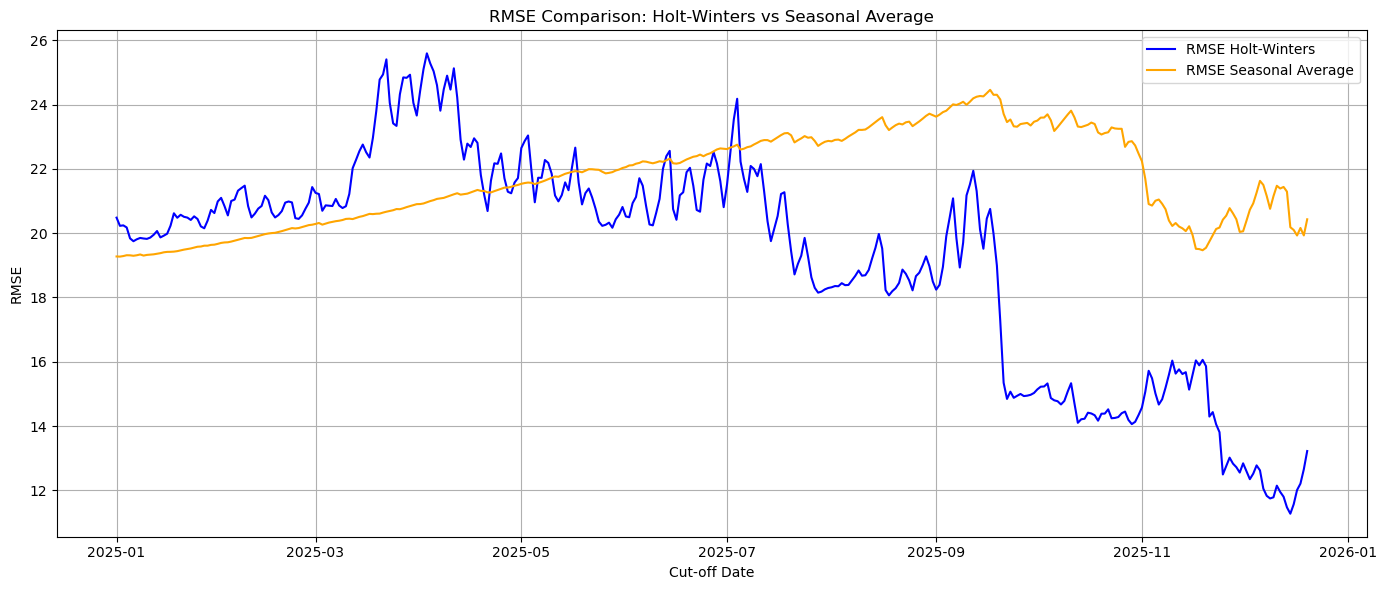

In [16]:

metrics_table['cut_off_date'] = pd.to_datetime(metrics_table['cut_off_date'])

plt.figure(figsize=(14,6))
plt.plot(metrics_table['cut_off_date'], metrics_table['rmse_hw'], label='RMSE Holt-Winters', color='blue')
plt.plot(metrics_table['cut_off_date'], metrics_table['rmse_sa'], label='RMSE Seasonal Average', color='orange')
plt.xlabel('Cut-off Date')
plt.ylabel('RMSE')
plt.title('RMSE Comparison: Holt-Winters vs Seasonal Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## CONCLUSIONS

It appears that the HOLT-WINTERS model gets better around roughly 2026-06-01 cut-off date and stays better for most of the remaining cut offs.